# **Reading and Pre-Processing**

In [1]:
# %%capture  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install vrplib
import vrplib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import math

#Replace here the instance & solution directories with your own directories
instance = vrplib.read_instance(r"C:\Users\070ak\Desktop\KU Classroom\Sem4\Digital Project\Codes n stuffs\Vrp-Set-XML100\instances1\XML100_1175_01.vrp")
solutions = vrplib.read_solution(r"C:\Users\070ak\Desktop\KU Classroom\Sem4\Digital Project\Codes n stuffs\Vrp-Set-XML100\solutions\XML100_1175_01.sol")

#instance = vrplib.read_instance(r'/content/drive/MyDrive/XML100_1171_01.vrp')
#solutions = vrplib.read_solution(r'/content/drive/MyDrive/XML100_1171_01.sol')


In [2]:
instance.keys()


dict_keys(['name', 'comment', 'type', 'dimension', 'edge_weight_type', 'capacity', 'node_coord', 'demand', 'depot', 'edge_weight'])

In [3]:

# print(type(instance['node_coord']))
print(solutions.keys())
print(solutions['cost'])
# print(instance.keys())

dict_keys(['routes', 'cost'])
11552


In [8]:
# converting the node_coord to pandas dataframe and rename them to X and Y coordinates respectively

node_coord_df = pd.DataFrame(instance['node_coord'], columns=['X', 'Y'])

# node_coord_df= node_coord_df.drop(index=0)
node_coord_df.reset_index(drop=True, inplace = True)

# set nodeID and convert into a column and index

node_coord_df['NodeID'] = np.arange(0, len(node_coord_df) )
node_coord_df = node_coord_df[['NodeID', 'X', 'Y']]

#renaming the demand as Demand and setting the index

demand_df = pd.DataFrame(instance['demand'],columns=['Demand'], index=np.arange(0, len(instance['demand'])))
# print("The sum of the demand in the current instance is:", str(demand_df.sum()))

# merging the dataframes

instances_df = pd.merge(node_coord_df, demand_df, left_on='NodeID', right_index=True)
instances_df = instances_df.fillna(0).astype(int)

# solutions['routes'] is list of lists

modified_routes = [[0] + route + [0] for route in solutions['routes']]
solutions_df = pd.DataFrame(modified_routes)
print(modified_routes)


[[0, 18, 29, 0], [0, 65, 24, 73, 69, 2, 60, 52, 98, 64, 39, 22, 77, 0], [0, 16, 100, 85, 21, 38, 75, 48, 17, 76, 68, 26, 74, 31, 97, 87, 70, 10, 32, 99, 36, 62, 90, 84, 35, 9, 44, 12, 51, 45, 54, 0], [0, 33, 15, 13, 40, 8, 56, 59, 37, 55, 78, 96, 42, 4, 58, 30, 93, 83, 11, 67, 66, 0], [0, 91, 61, 92, 47, 1, 57, 23, 14, 50, 20, 27, 89, 19, 41, 0], [0, 79, 6, 43, 95, 3, 81, 82, 53, 63, 71, 28, 25, 49, 5, 88, 7, 46, 34, 86, 72, 94, 80, 0]]


In [9]:
instances_df.columns

Index(['NodeID', 'X', 'Y', 'Demand'], dtype='object')

In [7]:
#@title **Demand Difference**

# Create a 2D matrix where each entry (i, j) is the difference in demand between the i-th and j-th entry

demand = np.array(instances_df['Demand'])
demand_differences = np.subtract.outer(demand, demand)
demand_differences = demand_differences.flatten()
print(demand_differences.shape)

(10201,)


In [10]:
#@title **Pairwise Distances**

# pdist calculates the euclidean distance between two points in R^2

distances = pdist(instances_df[['X', 'Y']], metric='euclidean')
distance_matrix= (squareform(distances))
pairwise_distances = distance_matrix.flatten()
# print((pd.DataFrame(distance_matrix)).shape)
print(pairwise_distances.shape)


(10201,)


In [11]:
#@title **Nearest Neighbor**

def calculate_distance_matrix(coordinates):
    """
    Calculate the distance matrix between coordinates.
    """
    num_points = len(coordinates)
    dist_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            dist_matrix[i, j] = calculate_distance(coordinates, i, j)

    return dist_matrix

def calculate_distance(coordinates, i, j):
    """
    Calculate the Euclidean distance between two points.
    """
    x1, y1 = coordinates[i]
    x2, y2 = coordinates[j]
    return round(np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2), 1)

def nearest_neighbor(dist_matrix, demands, capacity):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    num_points = dist_matrix.shape[0]
    visited = np.zeros(num_points, dtype=bool)
    routes = []

    while np.sum(visited) < num_points:
        current_node = 0  # Start at node 0
        current_capacity = 0
        route = [current_node]
        visited[current_node] = True

        while current_capacity + demands[current_node] <= capacity:
            current = route[-1]
            nearest = None
            min_dist = float('inf')

            for neighbor in np.where(~visited)[0]:
                if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
                    nearest = neighbor
                    min_dist = dist_matrix[current, neighbor]

            if nearest is None:
                break

            route.append(nearest)
            visited[nearest] = True
            current_capacity += demands[nearest]

        routes.append(route)

    return routes

def vrp_solver(instance_file, capacity):
    """
    Solve the VRP using the provided instance file and vehicle capacity.
    """
    instance = vrplib.read_instance(instance_file)
    coordinates = instance['node_coord']
    demands = instance['demand']

    dist_matrix = calculate_distance_matrix(coordinates)
    routes = nearest_neighbor(dist_matrix, demands, capacity)
    formatted_routes = format_output(routes)
    total_distance = calculate_total_distance(routes, dist_matrix)

    return routes, total_distance, coordinates

def calculate_total_distance(routes, dist_matrix):
    """
    Calculate the total distance of all routes.
    """
    total_distance = 0
    for route in routes:
        for i in range(len(route) - 1):
            total_distance += dist_matrix[route[i], route[i + 1]]
    return total_distance

def format_output(routes):
    """
    Format the final routes as required.
    In this example, it returns a list of routes.
    """
    formatted_routes = []
    for i, route in enumerate(routes, 1):
        formatted_route = {'Route': i, 'Nodes': route}
        formatted_routes.append(formatted_route)
    return formatted_routes

def calculate_distance_nodes(node1, node2, instances_df):
    """
    Calculate the Euclidean distance between two nodes.
    """
    x1, y1 = instances_df.loc[instances_df['NodeID'] == node1, ['X', 'Y']].values[0]
    x2, y2 = instances_df.loc[instances_df['NodeID'] == node2, ['X', 'Y']].values[0]
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

def plot_routes(routes, instances_df):
    """
    Plot the VRP routes using Plotly.
    """
    fig = make_subplots(rows=1, cols=1)

    # Extract depot coordinates
    depot_x, depot_y = instances_df.loc[instances_df['NodeID'] == 0, ['X', 'Y']].values[0]
    fig.add_trace(go.Scatter(x=[depot_x], y=[depot_y], mode='markers', marker=dict(color='black', size=25, symbol='star'), name='Depot'))

    # Initialize total_distance
    total_distance = 0

    for route in routes:
        # Add depot to the start and end of the route
        route_with_depot = [0] + route + [0]
        # Calculate the distance for the current route
        for i in range(len(route_with_depot) - 1):
            total_distance += calculate_distance_nodes(route_with_depot[i], route_with_depot[i + 1], instances_df)

    for i, route in enumerate(routes, 1):
        # Add depot coordinates at the start and end of the route
        route_with_depot = [0] + route + [0]

        # Extract the X and Y coordinates for each node in the route
        x = [instances_df.loc[instances_df['NodeID'] == node_id, 'X'].values[0] for node_id in route_with_depot]
        y = [instances_df.loc[instances_df['NodeID'] == node_id, 'Y'].values[0] for node_id in route_with_depot]

        # Plot the route except for the last edge
        fig.add_trace(go.Scatter(x=x[:-1], y=y[:-1], mode='lines+markers', name=f'Route {i}'))

        # Plot the last edge with a dotted line
        fig.add_trace(go.Scatter(x=[x[-2], x[-1]], y=[y[-2], y[-1]], mode='lines', line=dict(color='grey', width=2, dash='dot'), showlegend=False))

    # Update the layout with the total distance
    fig.update_layout(title=f'VRP Solution (Heuristic Method: Nearest Neighbor, Capacity: {capacity}, Total Distance: {total_distance:.2f})')
    fig.show()

def run_vrp_and_plot(instance_file, capacity):
    """
    Run the VRP solver and plot the routes.
    """
    routes, total_distance, coordinates = vrp_solver(instance_file, capacity)
    nodes = [i for i in range(len(coordinates))]
    instances_df = pd.DataFrame({'NodeID': nodes, 'X': [coord[0] for coord in coordinates], 'Y': [coord[1] for coord in coordinates]})

    # Print the final routes
    print(f"\nVehicle Capacity: {capacity}")
    for i, route in enumerate(routes, 1):
        print(f"Route {i}: {route}")

    plot_routes(routes, instances_df)

    return routes

# Specify instance file path with your own file path

instance_file =(r"C:\Users\070ak\Desktop\KU Classroom\Sem4\Digital Project\Codes n stuffs\Vrp-Set-XML100\instances1\XML100_1175_01.vrp")

# Varying vehicle capacity
vehicle_capacities = [176, 186, 196]
for capacity in vehicle_capacities:
    # Run optimization with different capacity and print routes
    run_vrp_and_plot(instance_file, capacity)

# Example: Get the routes for a specific capacity (e.g., 119)
specific_capacity = 176
routes_for_specific_capacity = run_vrp_and_plot(instance_file, specific_capacity)

# Store the routes in a variable
stored_routes = routes_for_specific_capacity
stored_routes = [route + [0] for route in stored_routes]


# Print the stored routes
print(f"\nStored Routes for vehicle capacity {specific_capacity}:")
for i, route in enumerate(stored_routes, 1):
    print(f"Route {i}: {route}")



Vehicle Capacity: 176
Route 1: [0, 79, 6, 91, 43, 95, 22, 39, 64, 60, 2, 52, 98, 69, 61, 65, 63, 71, 41, 28, 67, 11, 66, 33, 49]
Route 2: [0, 77, 80, 18, 94, 72, 86, 88, 5, 54, 25, 53, 82, 81, 3, 29, 7, 46, 34, 21, 38, 48, 9, 62]
Route 3: [0, 16, 100, 85, 75, 17, 76, 68, 26, 74, 31, 97, 87, 70, 99, 10, 32, 35, 12, 51, 45, 15, 83, 93, 30, 58, 4, 42, 96]
Route 4: [0, 19, 89, 47, 27, 1, 57, 23, 14, 50, 20, 78, 37, 92]
Route 5: [0, 73, 24, 13, 40, 8, 56, 59, 36, 90, 84, 44]
Route 6: [0, 55]



Vehicle Capacity: 186
Route 1: [0, 79, 6, 91, 43, 95, 22, 39, 64, 60, 2, 52, 98, 69, 61, 65, 63, 71, 41, 28, 67, 11, 66, 33, 25, 49, 72, 46, 38]
Route 2: [0, 77, 80, 18, 94, 86, 88, 5, 54, 29, 3, 82, 81, 53, 19, 89, 27, 1, 42, 96, 23, 14, 20, 78, 30, 92]
Route 3: [0, 16, 100, 85, 21, 34, 7, 48, 75, 17, 76, 68, 26, 74, 31, 97, 87, 70, 99, 10, 32, 35, 9, 12, 51, 45, 15, 83, 93, 58, 56, 62]
Route 4: [0, 73, 24, 47, 4]
Route 5: [0, 44, 84, 90, 40, 13, 8, 59, 37, 55, 57, 36]
Route 6: [0, 50]



Vehicle Capacity: 196
Route 1: [0, 79, 6, 91, 43, 95, 22, 39, 64, 60, 2, 52, 98, 69, 61, 65, 63, 71, 41, 28, 67, 11, 66, 33, 25, 49, 54, 5, 46]
Route 2: [0, 77, 80, 18, 94, 72, 86, 88, 7, 34, 21, 38, 48, 75, 17, 76, 68, 26, 74, 31, 97, 87, 70, 99, 10, 32, 35, 9, 12, 51, 45, 15, 83, 30, 58]
Route 3: [0, 29, 3, 82, 81, 53, 19, 89, 47, 27, 1, 42, 96, 23, 14, 20, 78, 56]
Route 4: [0, 16, 100, 85, 44, 84, 90, 62, 40, 13, 93, 4, 55, 37, 59, 8, 36, 57, 92]
Route 5: [0, 73, 24, 50]



Vehicle Capacity: 176
Route 1: [0, 79, 6, 91, 43, 95, 22, 39, 64, 60, 2, 52, 98, 69, 61, 65, 63, 71, 41, 28, 67, 11, 66, 33, 49]
Route 2: [0, 77, 80, 18, 94, 72, 86, 88, 5, 54, 25, 53, 82, 81, 3, 29, 7, 46, 34, 21, 38, 48, 9, 62]
Route 3: [0, 16, 100, 85, 75, 17, 76, 68, 26, 74, 31, 97, 87, 70, 99, 10, 32, 35, 12, 51, 45, 15, 83, 93, 30, 58, 4, 42, 96]
Route 4: [0, 19, 89, 47, 27, 1, 57, 23, 14, 50, 20, 78, 37, 92]
Route 5: [0, 73, 24, 13, 40, 8, 56, 59, 36, 90, 84, 44]
Route 6: [0, 55]



Stored Routes for vehicle capacity 176:
Route 1: [0, 79, 6, 91, 43, 95, 22, 39, 64, 60, 2, 52, 98, 69, 61, 65, 63, 71, 41, 28, 67, 11, 66, 33, 49, 0]
Route 2: [0, 77, 80, 18, 94, 72, 86, 88, 5, 54, 25, 53, 82, 81, 3, 29, 7, 46, 34, 21, 38, 48, 9, 62, 0]
Route 3: [0, 16, 100, 85, 75, 17, 76, 68, 26, 74, 31, 97, 87, 70, 99, 10, 32, 35, 12, 51, 45, 15, 83, 93, 30, 58, 4, 42, 96, 0]
Route 4: [0, 19, 89, 47, 27, 1, 57, 23, 14, 50, 20, 78, 37, 92, 0]
Route 5: [0, 73, 24, 13, 40, 8, 56, 59, 36, 90, 84, 44, 0]
Route 6: [0, 55, 0]


In [13]:
# @title **Converting the Solution of the Nearest Neighbor into the Features**

# routes = vrp_solver(instance_file, capacity)
# routes = routes.tolist()
print(len(stored_routes))
max_node_index = max(max(route) for route in stored_routes)

# Initialize an (n+1) x (n+1) adjacency matrix with zeros (n is max_node_index)
adjacency_matrix = np.zeros((max_node_index+1, max_node_index+1), dtype=int)

# Fill the adjacency matrix based on the routes
for route in stored_routes:
    for i in range(len(route) - 1):
        start_node = route[i]
        end_node = route[i + 1]
        adjacency_matrix[start_node, end_node] = 1
        adjacency_matrix[end_node, start_node] = 1  # Assuming undirected routes

print((adjacency_matrix).shape)
Nearest_Neighbor_feature = adjacency_matrix.flatten()
print(len(Nearest_Neighbor_feature))

print( "The no. of edges in the Solution of Nearest Neighbor is:", str(np.count_nonzero(Nearest_Neighbor_feature)))

def get_consecutive_tuples(nested_list):
  """
  This function takes a nested list and returns a list of tuples
  containing consecutive elements from each sublist.
  """
  all_tuples = []
  for sublist in nested_list:
    for i in range(len(sublist) - 1):  # Iterate up to the second-last element
      all_tuples.append(tuple([sublist[i], sublist[i + 1]]))
  return all_tuples


consecutive_tuples = get_consecutive_tuples(modified_routes)
print( "The no. of edges in the Solution after adding depot at the start and end to every route is:", str(len(consecutive_tuples)))
#print(type(consecutive_tuples))


6
(101, 101)
10201
The no. of edges in the Solution of Nearest Neighbor is: 210
The no. of edges in the Solution after adding depot at the start and end to every route is: 106


In [14]:
# @title **Calculating Distance of the Solutions' Instance file**

#'distance_matrix' is  matrix containing pairwise distances
# And 'consecutive_tuples' is list of tuples representing the consecutive nodes
total_distance = 0

for (start_node, end_node) in consecutive_tuples:
    total_distance += distance_matrix[start_node][end_node]

print(f"The total distance of the consecutive tuples is: {total_distance}")


The total distance of the consecutive tuples is: 11554.535104756525


In [15]:
#@title **Degree Difference Feature**

# Initialize the degree_nodes list with zeros

degree_nodes = [0] * (max_node_index+1)

# Calculate the degree for each node
for i in range(1, max_node_index):  # Start from 1 to skip the unused 0th index
    # Sum the row for out-degree
    out_degree = sum(adjacency_matrix[i])
    # Sum the column for in-degree using list comprehension
    in_degree = sum(row[i] for row in adjacency_matrix)
    # Assign the total degree to the degree_nodes list
    degree_nodes[i] = out_degree + in_degree

print((degree_nodes))
print(type(degree_nodes))

# Assuming degree_nodes is a NumPy array with the degrees of each node
degree_nodes = np.array(degree_nodes)

# pairwise absolute differences
absolute_differences = pdist(degree_nodes[:, np.newaxis], lambda u, v: np.abs(u - v))

# condensed distance matrix to a square matrix
difference_matrix = squareform(absolute_differences)

# Now difference_matrix is a square matrix containing the absolute differences
Degree_difference_feature = difference_matrix.flatten()



[0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0]
<class 'list'>


In [16]:
# @title **Demand Ratio Feature**

ratios = np.zeros_like(distance_matrix)
for i in range(len(demand)):
    for j in range(len(demand)):
        if adjacency_matrix[i, j] == 1:  # If there's an edge
            ratios[i, j] = adjacency_matrix[i, j] / (demand[i] + demand[j])

# 'ratios' now contains the ratio of distance to demand for each edge
demand_ratio_feature = ratios.flatten()

In [17]:
#@title **Target Label**

print(len(modified_routes))
max_node_indexes = max(max(route) for route in modified_routes)

# Initialize an (n+1) x (n+1) adjacency matrix with zeros (n is max_node_indexes)

adjacency_matrix1 = np.zeros((max_node_indexes+1, max_node_indexes+1), dtype=int)

# Fill the adjacency matrix based on the routes

for route in modified_routes:
    for i in range(len(route) - 1):
        start_node = route[i]
        end_node = route[i + 1]
        adjacency_matrix1[start_node, end_node] = 1
        adjacency_matrix1[end_node, start_node] = 1  # Assuming undirected routes

print((adjacency_matrix1).shape)

Target = adjacency_matrix1.flatten()
print(len(Target))
print(np.count_nonzero(Target))

6
(101, 101)
10201
212


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# @title **Creating the Feature Matrix**
demand_diff_vector = demand_differences
pairwise_distances_vector = pairwise_distances
degree_difference_vector = Degree_difference_feature
demand_ratio_vector = demand_ratio_feature
NN_feature = Nearest_Neighbor_feature

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Scaling features
pairwise_distances_vector_scaled = scaler.fit_transform(pairwise_distances_vector.reshape(-1, 1)).flatten()
demand_diff_vector_scaled = scaler.fit_transform(demand_diff_vector.reshape(-1, 1)).flatten()
Degree_difference_feature_scaled = scaler.fit_transform(degree_difference_vector.reshape(-1, 1)).flatten()
demand_ratio_vector_scaled = scaler.fit_transform(demand_ratio_vector.reshape(-1, 1)).flatten()


# Stack these vectors vertically to form the feature matrix
features_scaled = np.vstack([NN_feature, demand_diff_vector_scaled, pairwise_distances_vector_scaled, Degree_difference_feature_scaled, demand_ratio_vector_scaled]).T

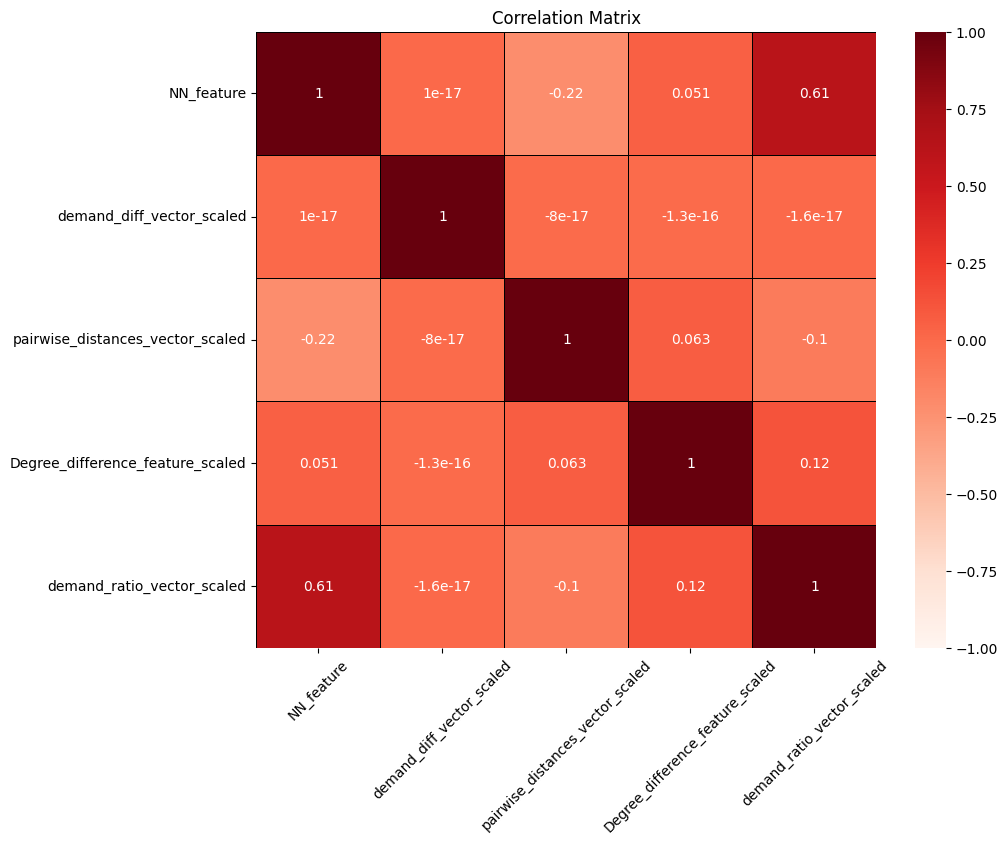

In [19]:
# @title **Correlation Plot**
feature_names = ['NN_feature', 'demand_diff_vector_scaled', 'pairwise_distances_vector_scaled', 'Degree_difference_feature_scaled', 'demand_ratio_vector_scaled']
features_df = pd.DataFrame(features_scaled, columns = feature_names)

# Calculate the correlation matrix
corr_matrix = features_df.corr()

# Plot the correlation matrix with a custom red to dark red color map
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Reds', vmin=-1, vmax=1, linewidths=0.5, linecolor='black')

plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [20]:
# @title **Plotting the Instance Solution and Heuristic Solution to see the edges in Adjacency Matrix**

# hover text for each cell
hover_text = [['' for _ in range(max_node_index + 1)] for _ in range(max_node_index + 1)]
for i in range(max_node_index):
    for j in range(max_node_index):
        if adjacency_matrix[i, j] == 1:
            hover_text[i][j] = f'Edge between {i} and {j}'
        else:
            hover_text[i][j] = f'No edge between {i} and {j}'

# subplots: use 'domain' type for side-by-side heatmaps
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Instance Solution', 'Nearest Neighbor Solution'),
    horizontal_spacing=0.2
)

# First heatmap for adjacency_matrix
fig.add_trace(
    go.Heatmap(
        z=adjacency_matrix,
        text=hover_text,
        hoverinfo='text',
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=1
)

# Second heatmap for adjacency_matrix1
fig.add_trace(
    go.Heatmap(
        z=adjacency_matrix1,
        text=hover_text,
        hoverinfo='text',
        colorscale='Viridis',
        showscale=False
    ),
    row=1, col=2
)

# Update layout for better visualization
fig.update_layout(
    title='Matrix Depicting Edges of Instance and Nearest Neighbor Solutions',
    width=1400,
    height=700
)


# Show the plot
fig.show()
pyo.plot(fig, filename='Purple_Plot.html')

'Purple_Plot.html'

In [21]:
# @title **Installing all the libraries Required to run the models**
# %%capture
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# !pip install ogb
# !pip install torch_geometric

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

Make sure to run the models independently and ensure that no model was run without restarting the kernel to ensure there is no data leakage

Accuracy: 0.9573738363547281
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1996
           1       0.29      0.64      0.40        45

    accuracy                           0.96      2041
   macro avg       0.64      0.80      0.69      2041
weighted avg       0.98      0.96      0.97      2041

Confusion Matrix:
[[1925   71]
 [  16   29]]


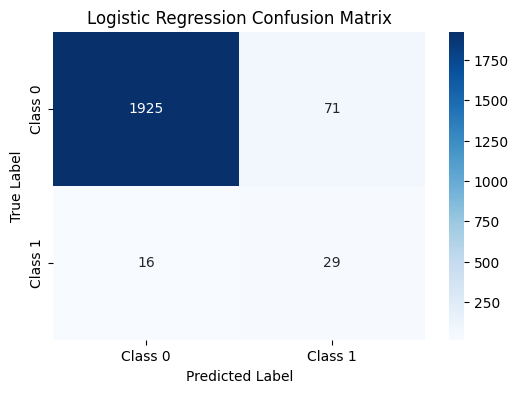

ROC-AUC Score: 0.9729


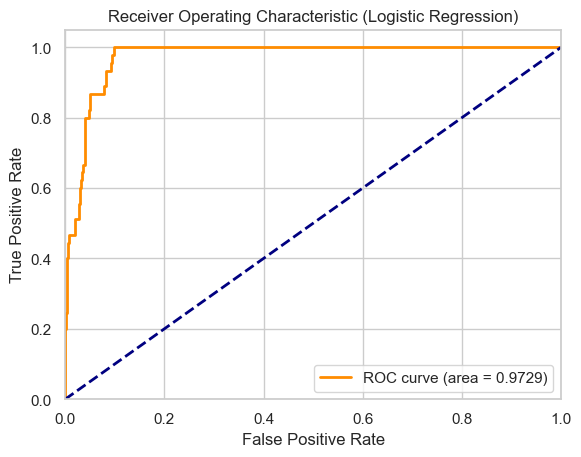

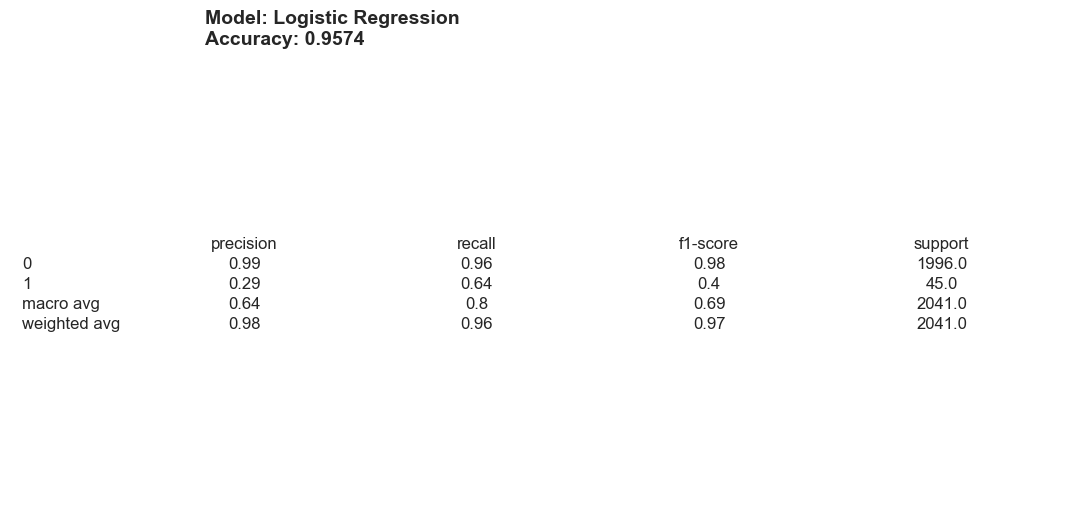

In [18]:

#@title **Logistic Regression**


# Stack these vectors vertically to form the feature matrix
features_scaled = np.vstack([NN_feature, demand_diff_vector_scaled, pairwise_distances_vector_scaled, Degree_difference_feature_scaled, demand_ratio_vector_scaled]).T
# features =  np.vstack([NN_feature, demand_diff_vector, pairwise_distances_vector,degree_difference_vector, demand_ratio_vector]).T

# our target labels (1 for used edges, 0 for unused)
target = Target  
# print(target.shape)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model with class weights
model = LogisticRegression(class_weight={0: 1, 1: 10})
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plotting confusion matrix 
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
sns.set(style="whitegrid")

# Plot ROC curve with Seaborn styling
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

# Assuming y_test and y_pred are defined
model_name = "Logistic Regression"  # Replace with your actual model name

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Adding accuracy to the DataFrame
accuracy = report_df.loc["accuracy"]["precision"]
report_df.drop(["accuracy"], axis=0, inplace=True)

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set size frame

ax.axis('tight')
ax.axis('off')

# Create a table without cell borders
table = ax.table(cellText=report_df.values.round(2),
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')

# Remove table lines
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Adding the accuracy value and model name
plt.title(f"Model: {model_name}\nAccuracy: {accuracy:.4f}", loc='left', fontsize=14, fontweight='bold')
plt.show()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

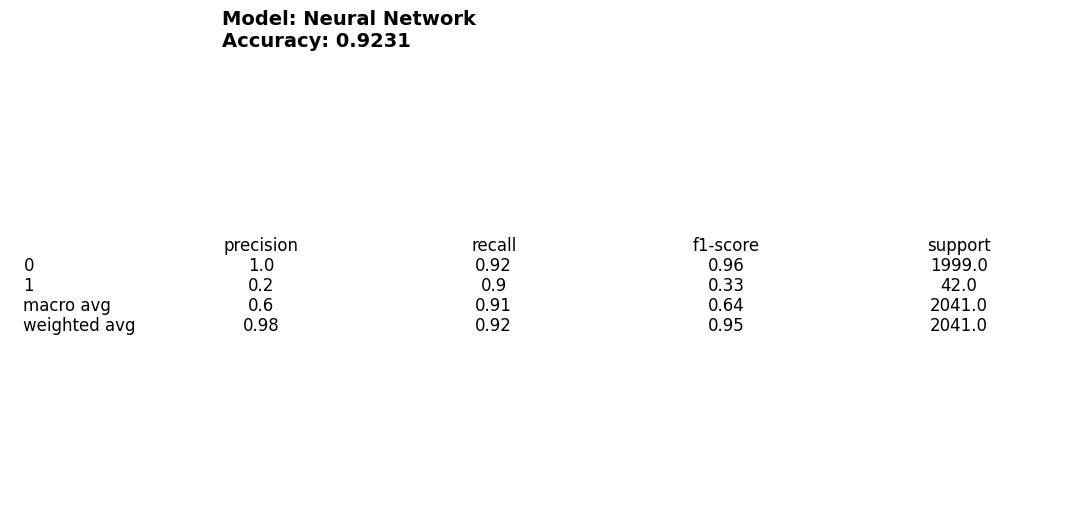

ROC-AUC Score: 0.9780


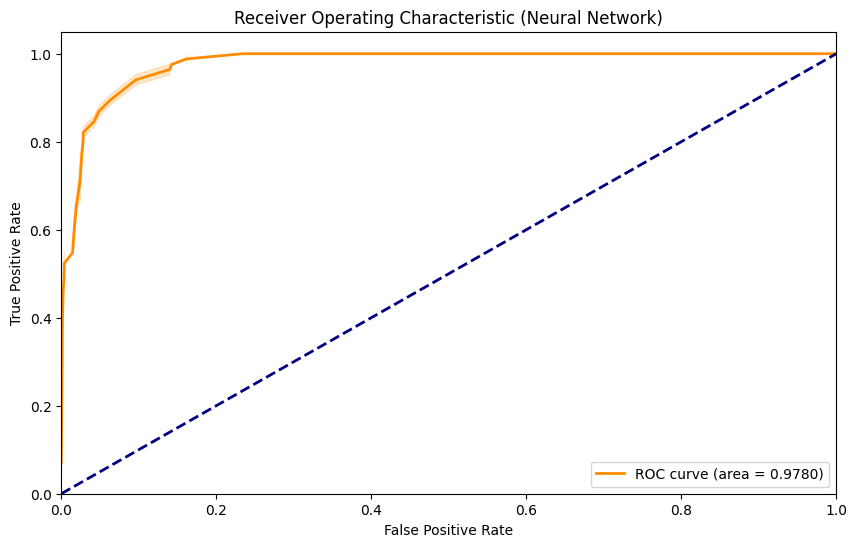

Confusion Matrix:
[[1846  153]
 [   4   38]]


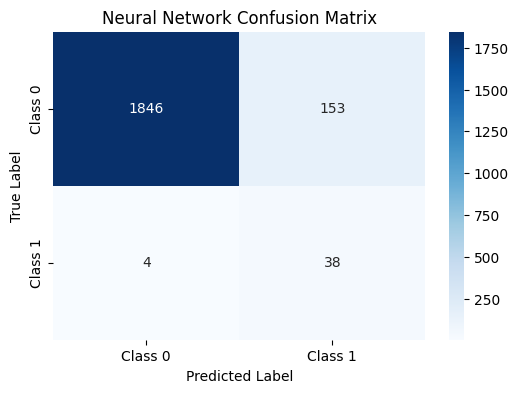

In [25]:
# @title **Neural Network**
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix


# features = np.vstack([demand_diff_vector, pairwise_distances_vector]).T
# features =  np.vstack([NN_feature, demand_diff_vector, pairwise_distances_vector,degree_difference_vector, demand_ratio_vector]).T
# print(features.shape)
features_scaled = np.vstack([NN_feature, demand_diff_vector_scaled, pairwise_distances_vector_scaled, Degree_difference_feature_scaled, demand_ratio_vector_scaled]).T
target = Target
# print(target.shape)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)

# SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)


#input_dim = X_train_resampled.shape[1]

model = Sequential()

model.add(Dense(128, input_dim=5, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
class_weights = {0: 1, 1: len(y_train) / np.sum(y_train == 1)}
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=32, validation_split=0.2, class_weight=class_weights)

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Assuming y_test and y_pred are defined
model_name = "Neural Network "  # Replace with your actual model name

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Adding accuracy to the DataFrame
accuracy = report_df.loc["accuracy"]["precision"]
report_df.drop(["accuracy"], axis=0, inplace=True)

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set size frame

ax.axis('tight')
ax.axis('off')

# Create a table without cell borders
table = ax.table(cellText=report_df.values.round(2),
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')

# Remove table lines
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Adding the accuracy value and model name
plt.title(f"Model: {model_name}\nAccuracy: {accuracy:.4f}", loc='left', fontsize=14, fontweight='bold')
plt.show()


# Compute ROC curve and ROC-AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=fpr, y=tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})', lw=2)
sns.lineplot(x=[0, 1], y=[0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Neural Network)')
plt.legend(loc="lower right")
plt.show()

# Compute and print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Neural Network Confusion Matrix")
plt.show()




Fitting 3 folds for each of 288 candidates, totalling 864 fits
Threshold: 0.01
Precision: 0.13, Recall: 1.00, F1-score: 0.23
False Negatives: 0, False Positives: 283

Threshold: 0.02
Precision: 0.15, Recall: 1.00, F1-score: 0.26
False Negatives: 0, False Positives: 243

Threshold: 0.03
Precision: 0.16, Recall: 1.00, F1-score: 0.27
False Negatives: 0, False Positives: 223

Threshold: 0.04
Precision: 0.16, Recall: 0.95, F1-score: 0.28
False Negatives: 2, False Positives: 205

Threshold: 0.05
Precision: 0.17, Recall: 0.93, F1-score: 0.29
False Negatives: 3, False Positives: 190

Threshold: 0.06
Precision: 0.18, Recall: 0.90, F1-score: 0.30
False Negatives: 4, False Positives: 176

Threshold: 0.07
Precision: 0.19, Recall: 0.90, F1-score: 0.31
False Negatives: 4, False Positives: 167

Threshold: 0.08
Precision: 0.19, Recall: 0.90, F1-score: 0.32
False Negatives: 4, False Positives: 159

Threshold: 0.09
Precision: 0.20, Recall: 0.90, F1-score: 0.32
False Negatives: 4, False Positives: 155

T

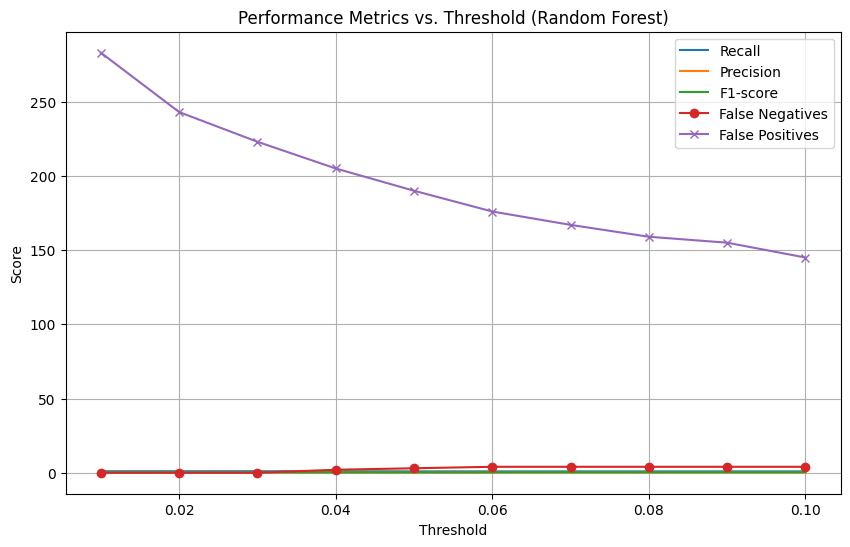

Best Threshold: 0.01
Minimum False Negatives: 0
Final Selected Threshold: 0.01
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1999
           1       0.13      1.00      0.23        42

    accuracy                           0.86      2041
   macro avg       0.56      0.93      0.58      2041
weighted avg       0.98      0.86      0.91      2041

Confusion Matrix:


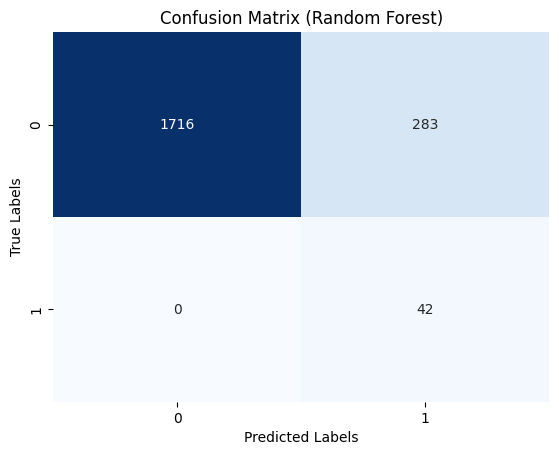

ROC-AUC Score: 0.9729


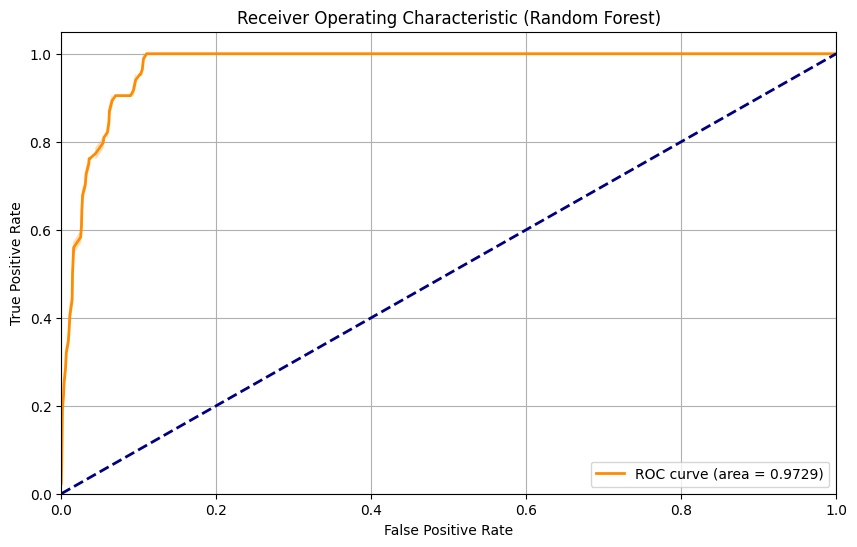

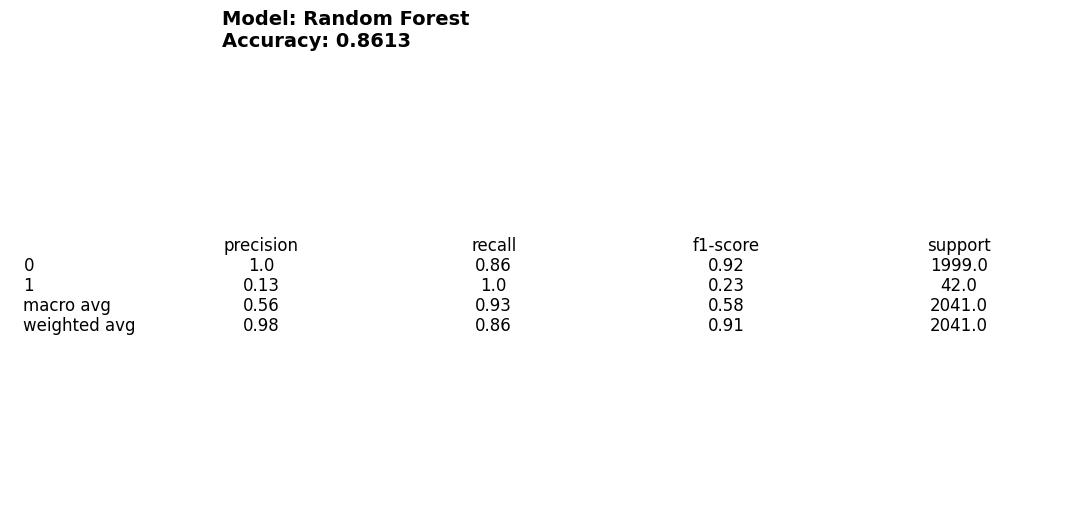

In [31]:


# @title Random Forest
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

np.random.seed(17)

# Assuming the following variables are already defined correctly:
# NN_feature, demand_diff_vector_scaled, pairwise_distances_vector_scaled, Degree_difference_feature_scaled, demand_ratio_vector_scaled, Target

# Combining features into a single array
features = np.vstack([NN_feature, demand_diff_vector_scaled, pairwise_distances_vector_scaled, Degree_difference_feature_scaled, demand_ratio_vector_scaled]).T
target = Target

X = features
y = target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=target)

# Apply SMOTE for handling class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# # Define parameter grid for RandomForestClassifier
# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'bootstrap': [True]
# }

# Define parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform Grid Search to find best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Get best parameters from Grid Search
best_params = grid_search.best_params_

# Initialize RandomForestClassifier with best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_res, y_train_res)

# Predict probabilities for the test set
y_probs = rf_best.predict_proba(X_test)[:, 1]  # Probabilities of positive class (class 1)

# Define thresholds to test (between 0.1 and 0.4)
# thresholds = [0.5]
# thresholds = np.linspace(0.1, 0.4, num=10)

thresholds = np.linspace(0.01, 0.1, num=10)

# Initialize lists to store results
precision_scores = []
recall_scores = []
f1_scores = []
false_negatives_list = []
false_positives_list = []  # List to store false positive counts

for threshold in thresholds:
    y_pred_thresh = (y_probs >= threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    conf_matrix = confusion_matrix(y_test, y_pred_thresh)
    false_negatives = conf_matrix[1, 0]  # False negatives
    false_positives = conf_matrix[0, 1]  # False positives

    # Append scores to lists
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    false_negatives_list.append(false_negatives)
    false_positives_list.append(false_positives)

    # Optional print statements
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
    print(f"False Negatives: {false_negatives}, False Positives: {false_positives}")
    print()

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.plot(thresholds, false_negatives_list, label='False Negatives', marker='o')
plt.plot(thresholds, false_positives_list, label='False Positives', marker='x')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Threshold (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold with the minimum false negatives or another criterion
best_threshold_idx = np.argmin(false_negatives_list)  # or another list based on your criterion
best_threshold = thresholds[best_threshold_idx]
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Minimum False Negatives: {false_negatives_list[best_threshold_idx]}")

# Evaluate performance with the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)

# Print final metrics with the best threshold
print("Final Selected Threshold:", best_threshold)
print(classification_report(y_test, y_pred_best))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Compute ROC curve and ROC-AUC score
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC curve using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=fpr, y=tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})', lw=2)
sns.lineplot(x=[0, 1], y=[0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Assuming y_test and y_pred_best are defined
model_name = "Random Forest"  # Replace with your actual model name

report = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Adding accuracy to the DataFrame
accuracy = report_df.loc["accuracy"]["precision"]
report_df.drop(["accuracy"], axis=0, inplace=True)

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set size frame

ax.axis('tight')
ax.axis('off')

# Create a table without cell borders
table = ax.table(cellText=report_df.values.round(2),
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center')

# Remove table lines
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Adding the accuracy value and model name
plt.title(f"Model: {model_name}\nAccuracy: {accuracy:.4f}", loc='left', fontsize=14, fontweight='bold')
plt.show()


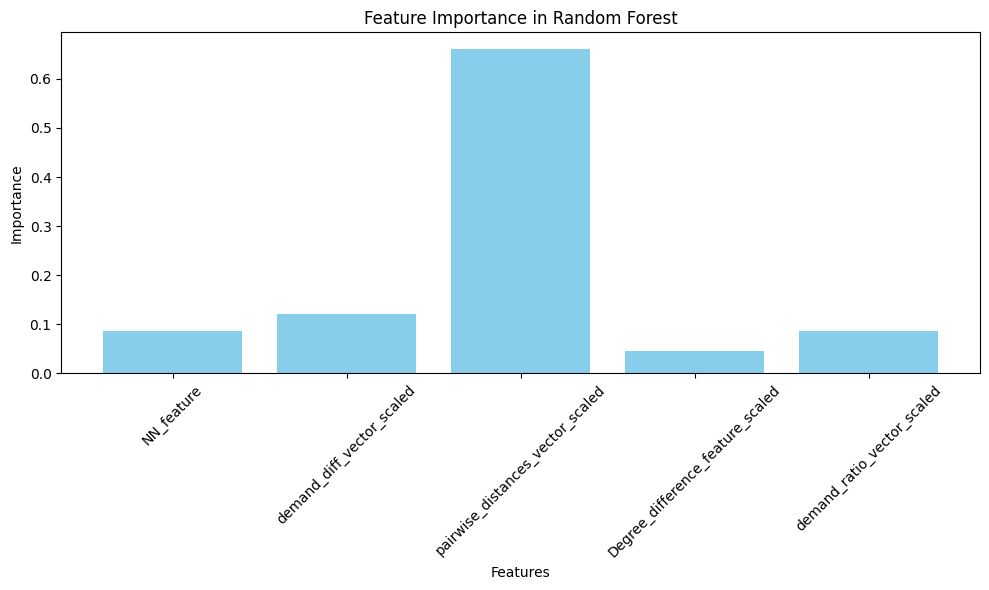

In [33]:
# Feature importances
feature_names = ['NN_feature', 'demand_diff_vector_scaled', 'pairwise_distances_vector_scaled', 'Degree_difference_feature_scaled', 'demand_ratio_vector_scaled']
importances = rf_best.feature_importances_  # Use rf_best instead of rf

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color='skyblue')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()
